In [4]:
import torch, torchvision
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights
from torch.optim import Adam

In [84]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)

train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

test_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

In [60]:
train_data = datasets.ImageFolder(root='Augmented_Data', transform=TwoCropTransform(train_transform))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)

In [97]:
test_data = datasets.ImageFolder(root='Augmented_TestData', transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)

In [62]:
print('train data size:', len(train_data))
print('test data size:', len(test_data))

train data size: 1393
test data size: 95


In [63]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1]) 
        self.fc = nn.Linear(512, 128)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc(x))
        x = F.normalize(x, dim=1)
        return x

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [65]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1) 
            if labels.shape[0] != batch_size:                                                         
                raise ValueError('Num of labels does not match num of features')                                                         
            mask = torch.eq(labels, labels.T).float().to(device)                                                         
        else:                                                         
            mask = mask.float().to(device)                                                         

        contrast_count = features.shape[1]                                                         
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)                                                         
        if self.contrast_mode == 'one':                                                         
            anchor_feature = features[:, 0]                                                         
            anchor_count = 1                                                         
        elif self.contrast_mode == 'all':                                                         
            anchor_feature = contrast_feature                                                         
            anchor_count = contrast_count                                                         
        else:                                                         
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))                                                         

        # compute logits                                                         
        anchor_dot_contrast = torch.div(                                                         
            torch.matmul(anchor_feature, contrast_feature.T),                                                         
            self.temperature)                                                         
        # for numerical stability                                                         
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)                                                         
        logits = anchor_dot_contrast - logits_max.detach()                                                         

        # tile mask                                                         
        mask = mask.repeat(anchor_count, contrast_count)                                                         
        # mask-out self-contrast cases                                                         
        logits_mask = torch.scatter(                                                         
            torch.ones_like(mask),                                                         
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point. 
        # Edge case e.g.:- 
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan] 
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [66]:
model = CNN().to(device)

/home/bolt17/miniconda3/envs/imgcap/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bolt17/miniconda3/envs/imgcap/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
opt = torch.optim.SGD(params=model.parameters(), lr=0.01, weight_decay=0.0005)
from torch.optim.lr_scheduler import StepLR
temp = 0.1
criterion_cont = SupConLoss(temperature=temp)
scheduler = StepLR(opt, step_size=30, gamma=0.1)

In [ ]:
epochs = 25
best_train_loss = float('inf')
counter = 0
bestmodel = None

for epoch in range(epochs):
    model.train()
    tr_loss=0
    total_train=0
    correct_train=0
    
    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs = torch.cat([inputs[0], inputs[1]], dim=0)
        if torch.cuda.is_available():
            inputs = inputs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
        bsz = labels.shape[0]
        
        outputs = model(inputs)
        f1, f2 = torch.split(outputs, [bsz, bsz], dim=0)
        outputs = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = criterion_cont(outputs, labels)
        tr_loss+=loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    avg_train_loss = tr_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{epochs}], loss - [{avg_train_loss}]')
    scheduler.step()

100%|██████████| 44/44 [00:59<00:00,  1.34s/it]


Epoch [1/25], loss - [3.5128049850463867]


100%|██████████| 44/44 [00:58<00:00,  1.32s/it]


Epoch [2/25], loss - [2.5321221351623535]


100%|██████████| 44/44 [00:58<00:00,  1.34s/it]


Epoch [3/25], loss - [2.2407631874084473]


100%|██████████| 44/44 [00:56<00:00,  1.28s/it]


Epoch [4/25], loss - [2.062028646469116]


100%|██████████| 44/44 [00:58<00:00,  1.34s/it]


Epoch [5/25], loss - [2.001171588897705]


100%|██████████| 44/44 [00:59<00:00,  1.36s/it]


Epoch [6/25], loss - [1.926790475845337]


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch [7/25], loss - [1.9286025762557983]


100%|██████████| 44/44 [00:57<00:00,  1.31s/it]


Epoch [8/25], loss - [1.8966245651245117]


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch [9/25], loss - [1.8757929801940918]


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch [10/25], loss - [1.8318790197372437]


100%|██████████| 44/44 [00:59<00:00,  1.36s/it]


Epoch [11/25], loss - [1.8129425048828125]


100%|██████████| 44/44 [00:59<00:00,  1.35s/it]


Epoch [12/25], loss - [1.8004274368286133]


100%|██████████| 44/44 [00:57<00:00,  1.31s/it]


Epoch [13/25], loss - [1.8835269212722778]


100%|██████████| 44/44 [00:58<00:00,  1.32s/it]


Epoch [14/25], loss - [1.7890880107879639]


100%|██████████| 44/44 [00:59<00:00,  1.34s/it]


Epoch [15/25], loss - [1.7820624113082886]


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch [16/25], loss - [1.7948856353759766]


100%|██████████| 44/44 [00:57<00:00,  1.31s/it]


Epoch [17/25], loss - [1.7944529056549072]


100%|██████████| 44/44 [00:59<00:00,  1.35s/it]


Epoch [18/25], loss - [1.780315637588501]


100%|██████████| 44/44 [00:59<00:00,  1.36s/it]


Epoch [19/25], loss - [1.7896006107330322]


100%|██████████| 44/44 [01:00<00:00,  1.38s/it]


Epoch [20/25], loss - [1.8055362701416016]


100%|██████████| 44/44 [00:58<00:00,  1.33s/it]


Epoch [21/25], loss - [1.8079005479812622]


100%|██████████| 44/44 [01:01<00:00,  1.39s/it]


Epoch [22/25], loss - [1.7767353057861328]


100%|██████████| 44/44 [01:00<00:00,  1.38s/it]


Epoch [23/25], loss - [1.8152018785476685]


100%|██████████| 44/44 [01:00<00:00,  1.37s/it]


Epoch [24/25], loss - [1.7602527141571045]


100%|██████████| 44/44 [01:00<00:00,  1.36s/it]


Epoch [25/25], loss - [1.8019587993621826]


RuntimeError: Parent directory ./paper does not exist.

In [95]:
model_save_path = "model_weights.pth"

# Save the model's state_dict (parameters)
torch.save(model.state_dict(), model_save_path)

In [92]:
model1=torch.load('contrastive_25epochs.pth').to(device)

/tmp/ipykernel_2447999/3969803457.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1=torch.load('contrastive_25epochs.pth').to(device)


In [70]:
import numpy as np
def extract_final_outputs(model, dataloader, device):
    outputs = []
    labels = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, (inputs, label) in enumerate(tqdm(train_loader)):
            inputs = torch.cat([inputs[0], inputs[1]], dim=0)
            # print(inputs.shape)
            if torch.cuda.is_available():
                inputs = inputs.cuda(non_blocking=True)
                label = label.cuda(non_blocking=True)
            bsz = label.shape[0]
            
            output = model(inputs)
            f1, f2 = torch.split(output, [bsz, bsz], dim=0)
            # Append the softmax probabilities and labels
            outputs.append(f1.cpu().numpy())
            labels.append(label.cpu().numpy())

    outputs = np.concatenate(outputs, axis=0)  # Concatenate all batches
    labels = np.concatenate(labels, axis=0)   # Concatenate all labels
    print(outputs.shape, labels.shape)

    return outputs, labels

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

final_outputs, labels = extract_final_outputs(model, train_loader, device)

100%|██████████| 44/44 [00:56<00:00,  1.29s/it]

(1393, 128) (1393,)


In [72]:
tsne = TSNE(n_components=2, random_state=42)
reduced_outputs = tsne.fit_transform(final_outputs)

/tmp/ipykernel_2447999/2865987627.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 19)  # 'tab20' colormap with 20 distinct colors


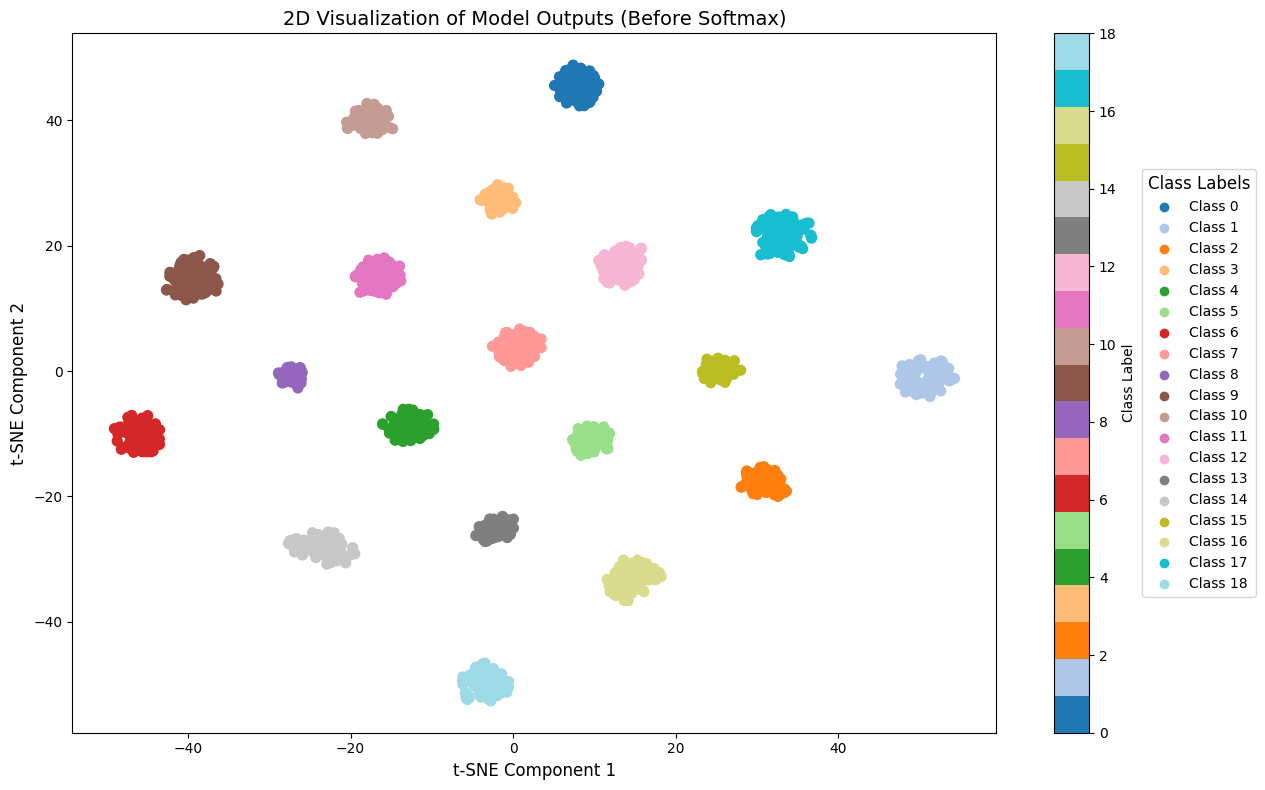

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Replace 'tab10' with 'tab20' to get more distinct colors
cmap = plt.cm.get_cmap('tab20', 19)  # 'tab20' colormap with 20 distinct colors

# Increase figure size for better spacing
plt.figure(figsize=(15, 8))
scatter = plt.scatter(reduced_outputs[:, 0], reduced_outputs[:, 1], c=labels, cmap=cmap, s=50)

# Add a colorbar with a label for class labels
cbar = plt.colorbar(scatter, label="Class Label")

# Title and axis labels
plt.title('2D Visualization of Model Outputs (Before Softmax)', fontsize=14)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Generate legend for all 19 classes
for i in range(19):
    plt.scatter([], [], c=[cmap(i)], label=f'Class {i}')  # Empty scatter points for legend

# Adjust legend and move it outside the plot area
plt.legend(title='Class Labels', bbox_to_anchor=(1.15, 0.5), loc='center left', fontsize=10, title_fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Shrink the plot to leave space for the legend
plt.show()


In [109]:
model = CNN().to(device)
model_save_path = "model_weights.pth"
model.load_state_dict(torch.load(model_save_path))
model = model.to(device)
# Make sure to set the model to evaluation mode if you're testing
model.eval()

print("Model weights loaded successfully.")


Model weights loaded successfully.


/home/bolt17/miniconda3/envs/imgcap/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bolt17/miniconda3/envs/imgcap/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_2447999/1817156775.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

In [110]:
import numpy as np

def calculate_mean_embeddings(final_outputs, labels, num_classes=19):
    mean_embeddings = []

    for i in range(num_classes):
        class_mask = (labels == i)
        class_embeddings = final_outputs[class_mask]
        
        class_mean_embedding = np.mean(class_embeddings, axis=0)
        mean_embeddings.append(class_mean_embedding)

    return np.array(mean_embeddings)

mean_embeddings = calculate_mean_embeddings(final_outputs, labels, num_classes=19)

for i, mean_embedding in enumerate(mean_embeddings):
    print(f"Mean embedding for class {i}: {mean_embedding}")


Mean embedding for class 0: [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.1216571e-01
 0.0000000e+00 5.4668140e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.7553287e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3897511e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.9086149e-03 2.7208449e-02 0.0000000e+00
 1.8179900e-03 0.0000000e+00 9.8792929e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2158731e-03
 5.0221652e-01 0.0000000e+00 4.9237895e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.8587150e-03 0.0000000e+00 0.0000000e+00 5.0963013e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.6572789e-03 0.0000

In [111]:
import pickle
import gzip

In [112]:
with gzip.open('mean_embeddings_latest.pkl.gz', 'wb') as f:
    pickle.dump(mean_embeddings, f)

print("mean_embeddings has been compressed and saved to mean_embeddings.pkl.gz")
# with gzip.open('mean_embeddings.pkl.gz', 'rb') as f:
#     mean_embeddings = pickle.load(f)

# print("mean_embeddings has been loaded successfully.")


mean_embeddings has been compressed and saved to mean_embeddings.pkl.gz


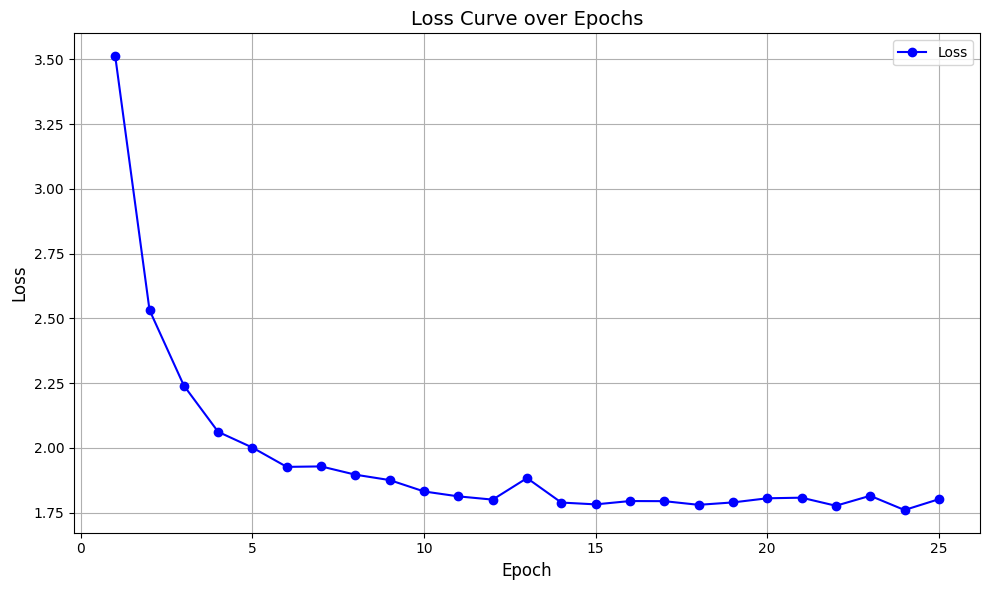

In [83]:
loss_values = [
    3.5128049850463867, 
    2.5321221351623535, 
    2.2407631874084473, 
    2.062028646469116, 
    2.001171588897705, 
    1.926790475845337, 
    1.9286025762557983, 
    1.8966245651245117, 
    1.8757929801940918, 
    1.8318790197372437, 
    1.8129425048828125, 
    1.8004274368286133, 
    1.8835269212722778, 
    1.7890880107879639, 
    1.7820624113082886, 
    1.7948856353759766, 
    1.7944529056549072, 
    1.780315637588501, 
    1.7896006107330322, 
    1.8055362701416016, 
    1.8079005479812622, 
    1.7767353057861328, 
    1.8152018785476685, 
    1.7602527141571045, 
    1.8019587993621826
]

import matplotlib.pyplot as plt

# Epochs corresponding to the loss values
epochs = list(range(1, len(loss_values) + 1))

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Loss')

# Title and labels
plt.title('Loss Curve over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Display the plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [118]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def extract_test_embeddings(model, test_loader, device):
    embeddings = []
    labels = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, (inputs, label) in enumerate(test_loader):
            
            if torch.cuda.is_available():
                inputs = inputs.cuda(non_blocking=True)
                label = label.cuda(non_blocking=True)
            
            # Get model output
            output = model(inputs)
            
            # Append the embeddings and labels
            embeddings.append(output.cpu().numpy())  # Embedding for the test data
            labels.append(label.cpu().numpy())   # Ground truth labels (if needed)

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    print(embeddings.shape, labels.shape)

    return embeddings, labels

def assign_class_to_test_images(test_embeddings, mean_embeddings):
    assigned_classes = []

    # For each test embedding, find the class with the highest similarity
    for i, test_embedding in enumerate(test_embeddings):
        if i==9:
            print(test_embedding)
        similarities = cosine_similarity([test_embedding], mean_embeddings)  # Cosine similarity
        best_class = np.argmax(similarities)  # Class with the highest similarity
        assigned_classes.append(best_class)

    return np.array(assigned_classes)

# Assuming you have your pretrained model and test_loader set up
test_embeddings, test_labels = extract_test_embeddings(model, test_loader, device)

# Now, use the mean embeddings that you've already calculated
assigned_classes = assign_class_to_test_images(test_embeddings, mean_embeddings)

# Calculate the accuracy
accuracy = np.mean(assigned_classes == test_labels)  # Compare predicted classes with ground truth

print(f"Accuracy: {accuracy * 100:.2f}%")


(95, 128) (95,)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01728784 0.03921093 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.56193763 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.41570634
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.5241102  0.         0.         0.         0.
 0.         0.0160013  0.         0.48438674 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

In [116]:
assigned_classes

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  4,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18])